# Heart Disease Prediction

This notebook explores a dataset with demographic information related to heart disease and different machine learning algorithms in order to create a prediction model.
This is a part of the course unit "Artificial Intelligence" of the Master in Informatics and Computing Engineering at FEUP.

#### Authors

| Name | Email |
|-----|----|
| José Luís Cunha Rodrigues | up202008462@fe.up.pt |
| Martim Raúl da Rocha Henriques | up202004421@fe.up.pt |
| Tiago Filipe Magalhães Barbosa | up202004926@fe.up.pt |

#### Imports

Firstly, we start by importing the necessay dependencies:

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm


#### Analysis of the data

The dataset is composed of 18 features, most of which are related to the health condition of each individual. The target variable is the presence of heart disease in the patient, which is a binary variable. Most features are binary and some are continuos. The dataset is composed of 319795 entries.

There are no null values in the dataset. In the following cells, we will expose a summary of the dataset.

In [3]:
pd.set_option('display.max_columns', None)

df = pd.read_csv("heart_disease.csv")

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [5]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

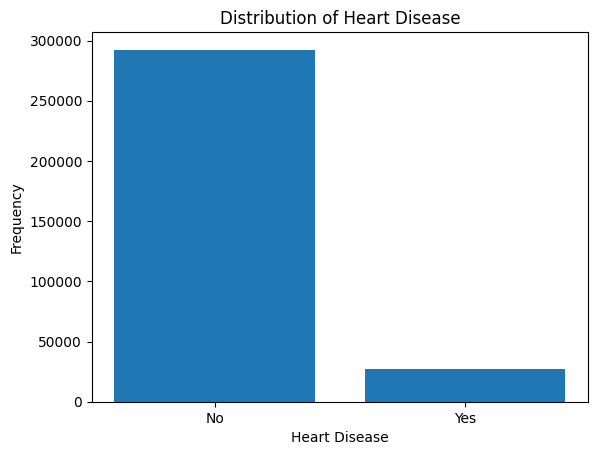

In [6]:
counts = df["HeartDisease"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel("Heart Disease")
plt.ylabel("Frequency")
plt.title("Distribution of Heart Disease")
plt.show()

We can see that the data is imbalanced. Most of the patients analyzed were healthy. This means that we may obtain skewed results, so it is something to deal with later on.

#### Data preprocessing

The column for physical health and mental health have a lot of zeros (>65%) which probably indicates lack of data so you opted to don't use these parameters.

In [7]:
new_df = df.copy()  # create a copy of the original dataframe

physicalHealth = new_df['PhysicalHealth'].describe()
print(physicalHealth)

# Calculate the percentage of values equal to 0
percentage_zero = (new_df['PhysicalHealth'] == 0).mean() * 100

# Print the result
print(f"The percentage of Physical Health values equal to 0: {percentage_zero}%")




count    319795.00000
mean          3.37171
std           7.95085
min           0.00000
25%           0.00000
50%           0.00000
75%           2.00000
max          30.00000
Name: PhysicalHealth, dtype: float64
The percentage of Physical Health values equal to 0: 70.85445363435952%


In [8]:
mentalHealth = new_df['MentalHealth'].describe()
print(mentalHealth)

# Calculate the percentage of values equal to 0
percentage_zero = (new_df['MentalHealth'] == 0).mean() * 100

# Print the result
print(f"The percentage of Mental Health values equal to 0: {percentage_zero}%")

count    319795.000000
mean          3.898366
std           7.955235
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          30.000000
Name: MentalHealth, dtype: float64
The percentage of Mental Health values equal to 0: 64.22895917697275%


In [9]:
# drop meantal health and physical health collumns

new_df = new_df.drop(['MentalHealth', 'PhysicalHealth'], axis=1)

new_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


We must binarize the Sex collumn because the values are not ordinal:

In [10]:
# Get the unique race categories
sexes = new_df['Sex'].unique()

# Create new columns for each race category
for sex in sexes:
    new_df[sex] = (new_df['Sex'] == sex)
    
# Drop race column
new_df = new_df.drop("Sex", axis=1)
    
new_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Female,Male
0,No,16.60,Yes,No,No,No,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,True,False
1,No,20.34,No,No,Yes,No,80 or older,White,No,Yes,Very good,7.0,No,No,No,True,False
2,No,26.58,Yes,No,No,No,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,False,True
3,No,24.21,No,No,No,No,75-79,White,No,No,Good,6.0,No,No,Yes,True,False
4,No,23.71,No,No,No,Yes,40-44,White,No,Yes,Very good,8.0,No,No,No,True,False


The AgeCategory is Ordinal so we must change it to give meaning to the data. We will be taking the mean of the age so we get a numerical value.

In [11]:
# Define a function to transform the age category into a representative value
def transform_age(row):
    age_range = str(row['AgeCategory']).split('-')
    if (len(age_range) == 1):
      return 80
    age_lower = int(age_range[0])
    age_upper = int(age_range[1])
    age_representative = (age_lower + age_upper) / 2
    return age_representative

# Apply the transformation to every row in the DataFrame
new_df['AgeCategory'] = new_df.apply(transform_age, axis=1)

new_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Female,Male
0,No,16.60,Yes,No,No,No,57.0,White,Yes,Yes,Very good,5.0,Yes,No,Yes,True,False
1,No,20.34,No,No,Yes,No,80.0,White,No,Yes,Very good,7.0,No,No,No,True,False
2,No,26.58,Yes,No,No,No,67.0,White,Yes,Yes,Fair,8.0,Yes,No,No,False,True
3,No,24.21,No,No,No,No,77.0,White,No,No,Good,6.0,No,No,Yes,True,False
4,No,23.71,No,No,No,Yes,42.0,White,No,Yes,Very good,8.0,No,No,No,True,False


We need to binarize the Race collumn so we can use it in the machine learning algortihms

In [12]:
# Get the unique race categories
races = new_df['Race'].unique()

# Create new columns for each race category
for race in races:
    new_df[race] = (new_df['Race'] == race)
    
# Drop race column
new_df = new_df.drop("Race", axis=1)
    
new_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Female,Male,White,Black,Asian,American Indian/Alaskan Native,Other,Hispanic
0,No,16.60,Yes,No,No,No,57.0,Yes,Yes,Very good,5.0,Yes,No,Yes,True,False,True,False,False,False,False,False
1,No,20.34,No,No,Yes,No,80.0,No,Yes,Very good,7.0,No,No,No,True,False,True,False,False,False,False,False
2,No,26.58,Yes,No,No,No,67.0,Yes,Yes,Fair,8.0,Yes,No,No,False,True,True,False,False,False,False,False
3,No,24.21,No,No,No,No,77.0,No,No,Good,6.0,No,No,Yes,True,False,True,False,False,False,False,False
4,No,23.71,No,No,No,Yes,42.0,No,Yes,Very good,8.0,No,No,No,True,False,True,False,False,False,False,False


The genHealth collumn is Ordinal so we can do label encoding to transform the categories into something ordered:

In [13]:
# Define the mapping of categories to numerical labels
label_mapping = {'Excellent': 10, 'Very good': 8, 'Good':6 , 'Fair': 3, 'Poor': 0}

# Apply label encoding to the column
new_df['GenHealth'] = new_df['GenHealth'].map(label_mapping)

new_df.head()



,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Female,Male,White,Black,Asian,American Indian/Alaskan Native,Other,Hispanic
0,No,16.60,Yes,No,No,No,57.0,Yes,Yes,8,5.0,Yes,No,Yes,True,False,True,False,False,False,False,False
1,No,20.34,No,No,Yes,No,80.0,No,Yes,8,7.0,No,No,No,True,False,True,False,False,False,False,False
2,No,26.58,Yes,No,No,No,67.0,Yes,Yes,3,8.0,Yes,No,No,False,True,True,False,False,False,False,False
3,No,24.21,No,No,No,No,77.0,No,No,6,6.0,No,No,Yes,True,False,True,False,False,False,False,False
4,No,23.71,No,No,No,Yes,42.0,No,Yes,8,8.0,No,No,No,True,False,True,False,False,False,False,False


 The diabetes collumn like the race collumn should be binarized so you can have a collumn for each possible value:

In [14]:
# Get the unique race categories
diabetes = new_df['Diabetic'].unique()

# Create new columns for each race category
for diabete in diabetes:
    new_df["Diabetes: " + diabete] = (new_df['Diabetic'] == diabete)
    
# Drop race column
new_df = new_df.drop("Diabetic", axis=1)
    
new_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Female,Male,White,Black,Asian,American Indian/Alaskan Native,Other,Hispanic,Diabetes: Yes,Diabetes: No,"Diabetes: No, borderline diabetes",Diabetes: Yes (during pregnancy)
0,No,16.60,Yes,No,No,No,57.0,Yes,8,5.0,Yes,No,Yes,True,False,True,False,False,False,False,False,True,False,False,False
1,No,20.34,No,No,Yes,No,80.0,Yes,8,7.0,No,No,No,True,False,True,False,False,False,False,False,False,True,False,False
2,No,26.58,Yes,No,No,No,67.0,Yes,3,8.0,Yes,No,No,False,True,True,False,False,False,False,False,True,False,False,False
3,No,24.21,No,No,No,No,77.0,No,6,6.0,No,No,Yes,True,False,True,False,False,False,False,False,False,True,False,False
4,No,23.71,No,No,No,Yes,42.0,Yes,8,8.0,No,No,No,True,False,True,False,False,False,False,False,False,True,False,False


Now for each Yes and No collumn lets transform it into True and False for the machine learning algorithms

In [15]:
# We need to change the column that have Yes and No to True and False respectively

new_df['HeartDisease'] = new_df['HeartDisease'].replace({'Yes': True, 'No': False})
new_df['Smoking'] = new_df['Smoking'].replace({'Yes': True, 'No': False})
new_df['AlcoholDrinking'] = new_df['AlcoholDrinking'].replace({'Yes': True, 'No': False})
new_df['Stroke'] = new_df['Stroke'].replace({'Yes': True, 'No': False})
new_df['DiffWalking'] = new_df['DiffWalking'].replace({'Yes': True, 'No': False})
new_df['PhysicalActivity'] = new_df['PhysicalActivity'].replace({'Yes': True, 'No': False})
new_df['Asthma'] = new_df['Asthma'].replace({'Yes': True, 'No': False})
new_df['KidneyDisease'] = new_df['KidneyDisease'].replace({'Yes': True, 'No': False})
new_df['SkinCancer'] = new_df['SkinCancer'].replace({'Yes': True, 'No': False})

new_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Female,Male,White,Black,Asian,American Indian/Alaskan Native,Other,Hispanic,Diabetes: Yes,Diabetes: No,"Diabetes: No, borderline diabetes",Diabetes: Yes (during pregnancy)
0,False,16.60,True,False,False,False,57.0,True,8,5.0,True,False,True,True,False,True,False,False,False,False,False,True,False,False,False
1,False,20.34,False,False,True,False,80.0,True,8,7.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False
2,False,26.58,True,False,False,False,67.0,True,3,8.0,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False
3,False,24.21,False,False,False,False,77.0,False,6,6.0,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False
4,False,23.71,False,False,False,True,42.0,True,8,8.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False


So the processed dataframe has the following collumns:

In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   HeartDisease                       319795 non-null  bool   
 1   BMI                                319795 non-null  float64
 2   Smoking                            319795 non-null  bool   
 3   AlcoholDrinking                    319795 non-null  bool   
 4   Stroke                             319795 non-null  bool   
 5   DiffWalking                        319795 non-null  bool   
 6   AgeCategory                        319795 non-null  float64
 7   PhysicalActivity                   319795 non-null  bool   
 8   GenHealth                          319795 non-null  int64  
 9   SleepTime                          319795 non-null  float64
 10  Asthma                             319795 non-null  bool   
 11  KidneyDisease                      3197

#### Correlation Matrix

In order to understand the correlation between the features, we will plot a correlation matrix. This will help us understand which features are more important to the prediction of heart disease.

<Axes: >

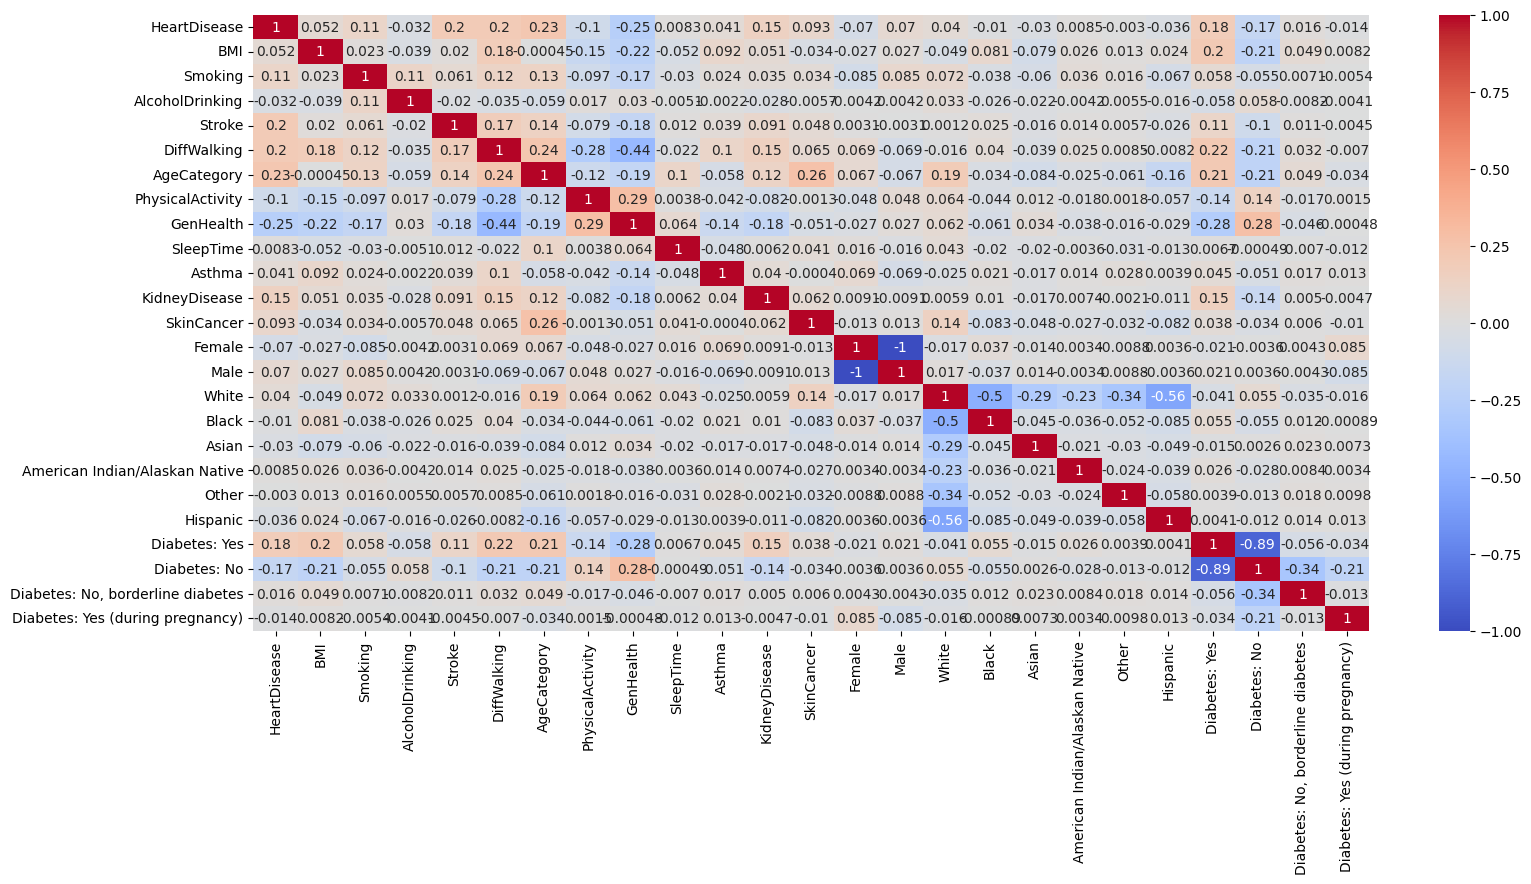

In [17]:
plt.figure(figsize=(18,8))
sb.heatmap(data=new_df.corr(),annot=True,cmap='coolwarm')

Taking a look at the matrix we observe that the variables more likely to affect Heart Disease are:
- Stroke
- DiffWalking
- AgeCategory
- Diabetic
- KidneyDisease

So now, we will take a closer look at how these variables affect the target variable.

#### Stroke

Text(0, 0.5, 'Percentage of Heart Disease Cases')

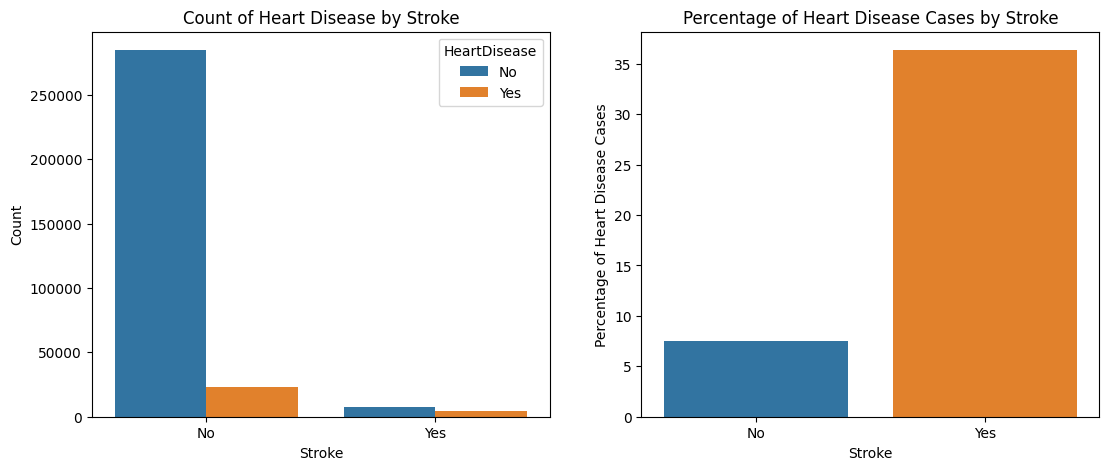

In [18]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# count plot
sb.countplot(x='Stroke', hue='HeartDisease', data=df, ax=ax1)
ax1.set_title('Count of Heart Disease by Stroke')
ax1.set_xlabel('Stroke')
ax1.set_ylabel('Count')

## percentage of people with heart disease by stroke
perc_stroke = df.groupby('Stroke')['HeartDisease'].value_counts(normalize=True)[:, 'Yes'] * 100

# Create bar plot
sb.barplot(x=perc_stroke.index, y=perc_stroke.values, ax=ax2)
ax2.set_title('Percentage of Heart Disease Cases by Stroke')
ax2.set_xlabel('Stroke')
ax2.set_ylabel('Percentage of Heart Disease Cases')


According to the graph above, there is a higher chance of having heart disease if the patient has had a stroke.
We can see that the percentage of people with heart disease that had a stroke was around five times higher than the percentage of people with heart disease that did not have a stroke.

#### Diff Walking

Text(0, 0.5, 'Percentage of Heart Disease Cases')

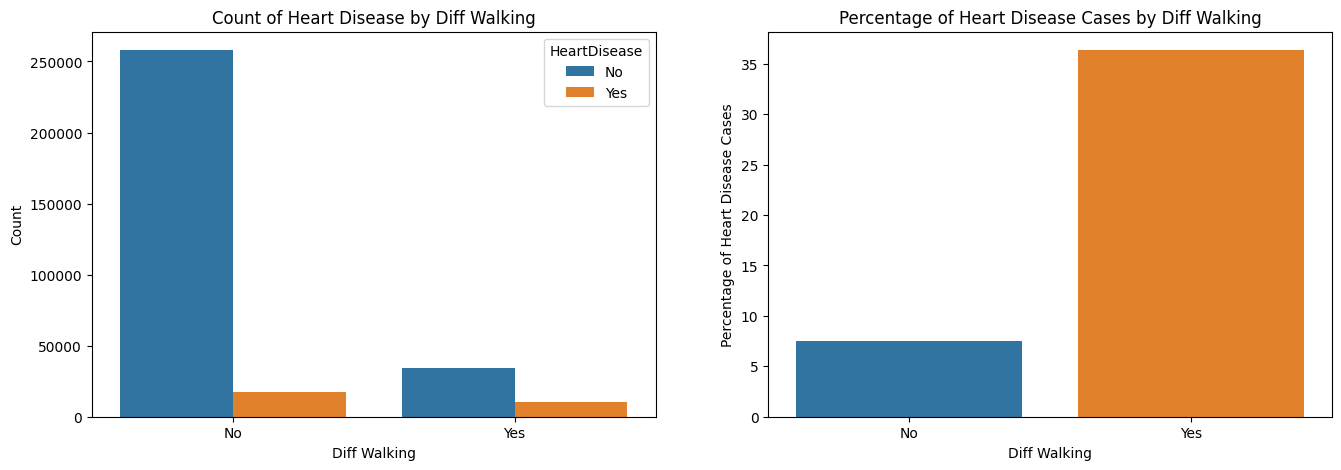

In [19]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# count plot
sb.countplot(x='DiffWalking', hue='HeartDisease', data=df, ax=ax1)
ax1.set_title('Count of Heart Disease by Diff Walking')
ax1.set_xlabel('Diff Walking')
ax1.set_ylabel('Count')

## percentage of people with heart disease by diff walking
perc_diff = df.groupby('DiffWalking')['HeartDisease'].value_counts(normalize=True)[:, 'Yes'] * 100

# Create bar plot
sb.barplot(x=perc_stroke.index, y=perc_stroke.values, ax=ax2)
ax2.set_title('Percentage of Heart Disease Cases by Diff Walking')
ax2.set_xlabel('Diff Walking')
ax2.set_ylabel('Percentage of Heart Disease Cases')

Again, we can state that the more a patient has difficulty walking, the more likely it is that he has heart disease. 
The percentage of people with heart disease that have difficulty walking is around 5 times higher than the percentage of people with heart disease that do not have difficulty walking.

#### Age Category

Text(0, 0.5, 'Percentage')

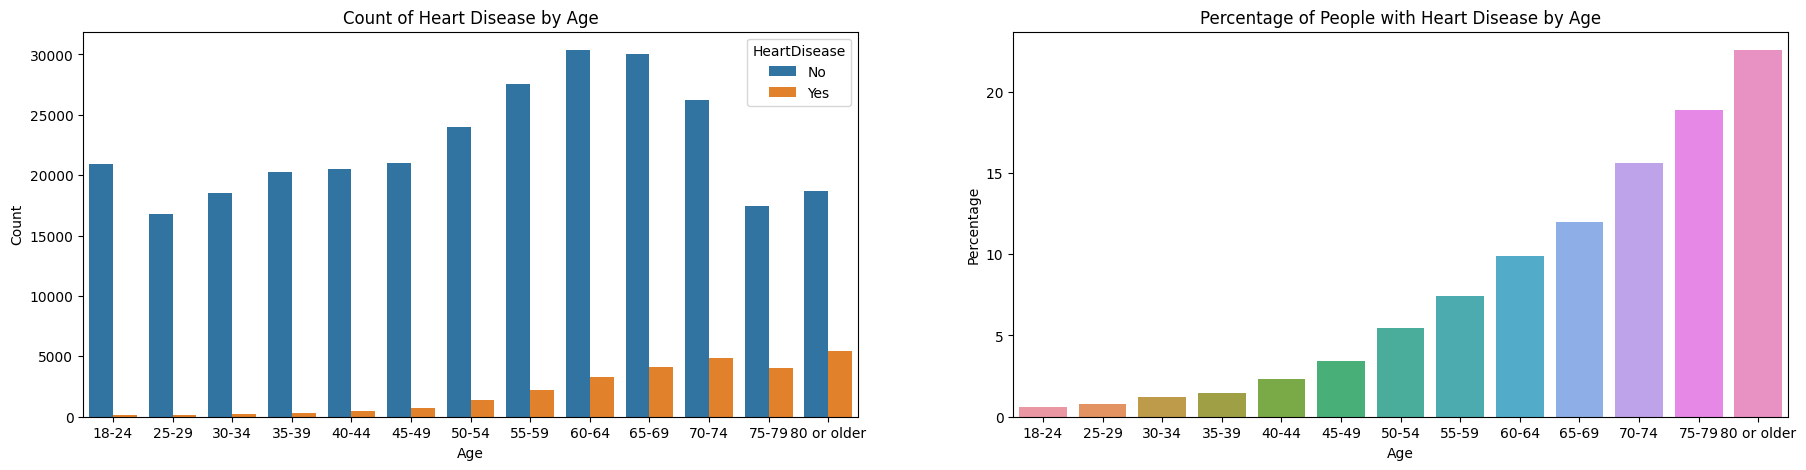

In [20]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 5))

# create a list of the age categories in the desired order
age_order = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# create a categorical variable with the desired order
df['AgeCategory'] = pd.Categorical(df['AgeCategory'], categories=age_order, ordered=True)

# plot count of heart disease by age category
sb.countplot(x='AgeCategory', hue='HeartDisease', data=df, ax=ax1)
ax1.set_title('Count of Heart Disease by Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

# plot percentage of people with heart disease by age category
age_df = df.groupby('AgeCategory')['HeartDisease'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
age_df = age_df[age_df['HeartDisease']=='Yes']
sb.barplot(x='AgeCategory', y='Percentage', data=age_df, ax=ax2)
ax2.set_title('Percentage of People with Heart Disease by Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Percentage')


As we can see on the above graph, the percentage of patients with heart disease consistently increases with age. 
It's also noticeable that the data is fairly distributed across all ages.

#### Diabetic

Text(0, 0.5, 'Percentage of Heart Disease Cases')

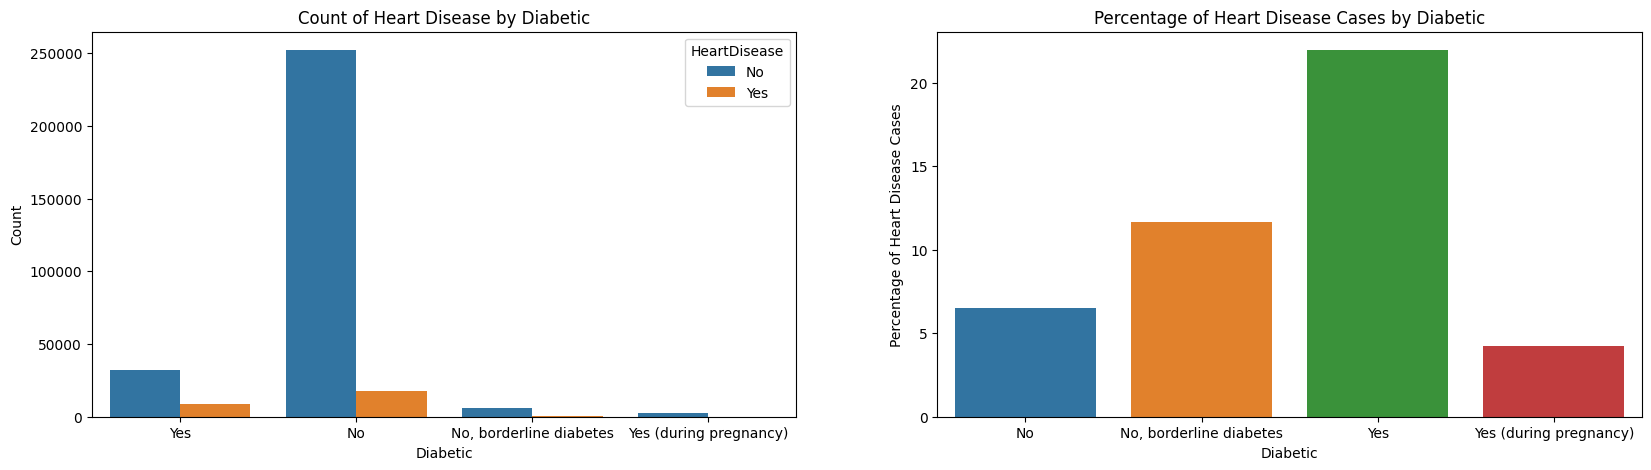

In [21]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sb.countplot(x='Diabetic', hue='HeartDisease', data=df, ax=ax1)
ax1.set_title('Count of Heart Disease by Diabetic')
ax1.set_xlabel('Diabetic')
ax1.set_ylabel('Count')

# create a grouped dataframe to calculate percentage
perc_stroke = df.groupby('Diabetic')['HeartDisease'].value_counts(normalize=True)[:, 'Yes'] * 100

# Create bar plot
sb.barplot(x=perc_stroke.index, y=perc_stroke.values, ax=ax2)
ax2.set_title('Percentage of Heart Disease Cases by Diabetic')
ax2.set_xlabel('Diabetic')
ax2.set_ylabel('Percentage of Heart Disease Cases')

In [22]:
# get the average age of diabetic during pregnancy
avg_age = df[df['Diabetic']=='Yes (during pregnancy)']
#avg_age["ageLower"] = avg_age["AgeCategory"].str.split("-").str[0].astype(int)
#avg_age.groupby('AgeCategory')['ageLower'].mean()

People with diabetes have a higher tendency to suffer from heart disease.


According to the graph, for patients with gestational diabetes (i.e. during pregnancy) leads to a lower percentage of heart disease.
Nevertheless, this can be due to a couple of reasons:
- The data is not representative enough
- This condition is only present during a limited period of a person's life
- The patients measured are expected to be younger than the average age of people with heart disease

#### Kidney Disease

Text(0, 0.5, 'Percentage of Heart Disease Cases')

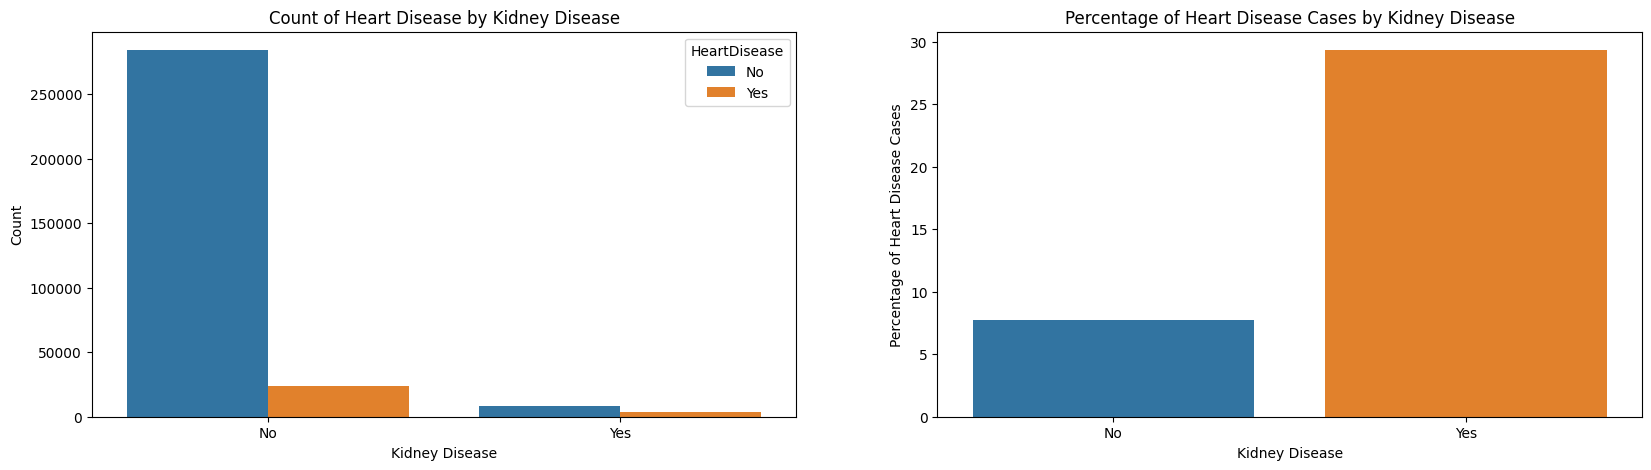

In [23]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sb.countplot(x='KidneyDisease', hue='HeartDisease', data=df, ax=ax1)
ax1.set_title('Count of Heart Disease by Kidney Disease')
ax1.set_xlabel('Kidney Disease')
ax1.set_ylabel('Count')

# create a grouped dataframe to calculate percentage
perc_stroke = df.groupby('KidneyDisease')['HeartDisease'].value_counts(normalize=True)[:, 'Yes'] * 100

# Create bar plot
sb.barplot(x=perc_stroke.index, y=perc_stroke.values, ax=ax2)
ax2.set_title('Percentage of Heart Disease Cases by Kidney Disease')
ax2.set_xlabel('Kidney Disease')
ax2.set_ylabel('Percentage of Heart Disease Cases')

As shown in the previous graph patients with kidney disease have a higher tendency to suffer from heart disease.
In this case, almost 30% of the patients with kidney disease also have heart disease. 
On the other hand, only around 7% of the patients without kidney disease have heart disease.

## Classification

Now, we can start the classification process. We will start by splitting the dataset into training and testing sets. The size of the testing set will be 20% of the total dataset.

Firstly, let's define general use functions:

In [25]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


def runModel(model, analysis=True):
    # Separate the target variable from predictors
    # df_short = df.iloc[:1000, :]
    X = new_df.drop('HeartDisease', axis=1)
    y = new_df['HeartDisease']

    # Convert categorical variables into numerical using one-hot encoding
    X = pd.get_dummies(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict the target variable for the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model's accuracy on the testing data
    accuracy = accuracy_score(y_test, y_pred)

    if analysis: analyze(model, X_test, y_test)

    return accuracy

def runModelRepeatedly(model):
    model_accuracies = []
    X = new_df.drop('HeartDisease', axis=1)
    y = new_df['HeartDisease']

    # Convert categorical variables into numerical using one-hot encoding
    X = pd.get_dummies(X)

    for _ in range(10):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        
        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Predict the target variable for the testing data
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        model_accuracies.append(accuracy)

    plt.hist(model_accuracies)

def analyze(knn, testing_inputs, testing_classes):
    knn.score(testing_inputs, testing_classes)

    y_pred = knn.predict(testing_inputs)

    accuracy = accuracy_score(testing_classes, y_pred)
    precision = precision_score(testing_classes, y_pred, average='weighted')
    recall = recall_score(testing_classes, y_pred, average='weighted')
    f1 = f1_score(testing_classes, y_pred, average='weighted')

    # Print the results
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 score:', f1)

    cm = confusion_matrix(testing_classes, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


#### Decision Tree

Accuracy: 0.8647414750074266
Precision: 0.8664642715358577
Recall: 0.8647414750074266
F1 score: 0.865597223699539


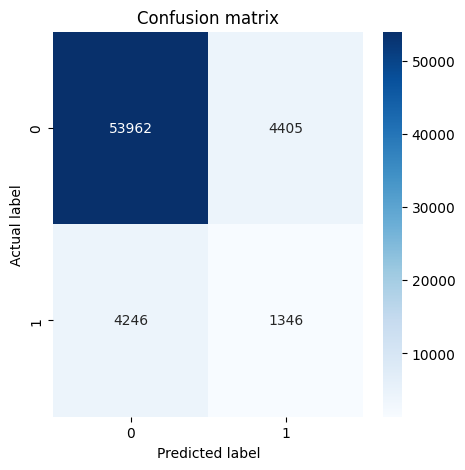

Accuracy: 0.8647414750074266


In [25]:
accuracy = runModel(DecisionTreeClassifier(random_state=42))
print("Accuracy: " + str(accuracy))

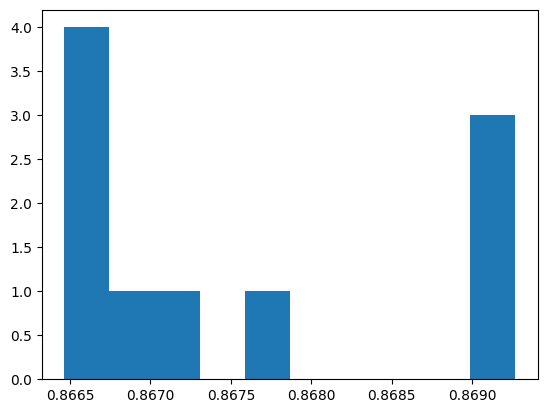

In [26]:
runModelRepeatedly(DecisionTreeClassifier())

#### Support Vector Machines (SVM)

In [27]:
clf = svm.SVC(kernel='linear')

# commenting out because it takes a long time to run
# accuracy = runModel(clf)
# print("Accuracy: " + str(accuracy))

In [28]:
# commenting out because it takes a long time to run
# runModelRepeatedly(clf)

#### K-Neighbours Classifier

Accuracy: 0.9049547366281524
Precision: 0.8705908456043
Recall: 0.9049547366281524
F1 score: 0.8810561677373056


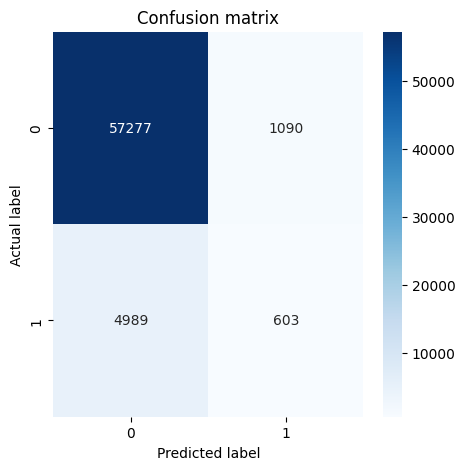

Accuracy: 0.9049547366281524


In [29]:
clf = KNeighborsClassifier(n_neighbors=5)
accuracy = runModel(clf)
print("Accuracy: " + str(accuracy))

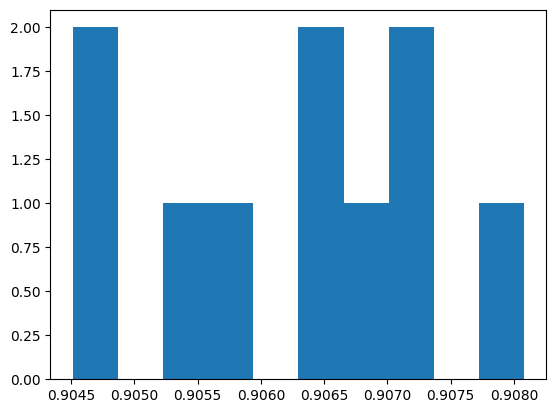

In [30]:
runModelRepeatedly(clf)

Accuracy: 0.8688691192795385
Precision: 0.8642027331214702
Recall: 0.8688691192795385
F1 score: 0.8664938893505904


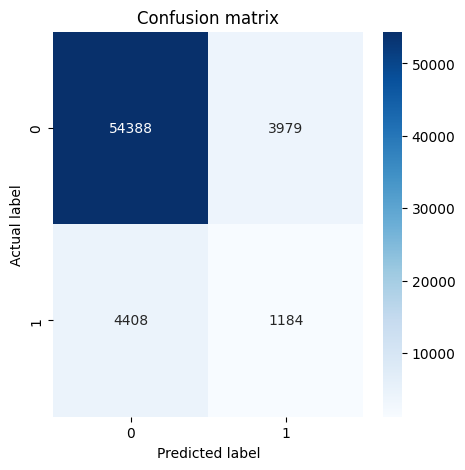

Accuracy: 0.9070967338451196
Precision: 0.8668219612518333
Recall: 0.9070967338451196
F1 score: 0.8777495081601283


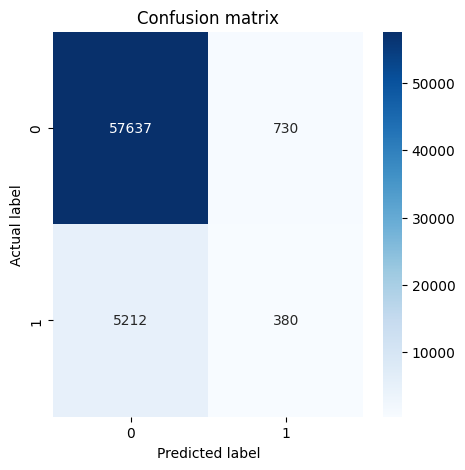

Accuracy: 0.8972154036179427
Precision: 0.869039460810417
Recall: 0.8972154036179427
F1 score: 0.8799890931982193


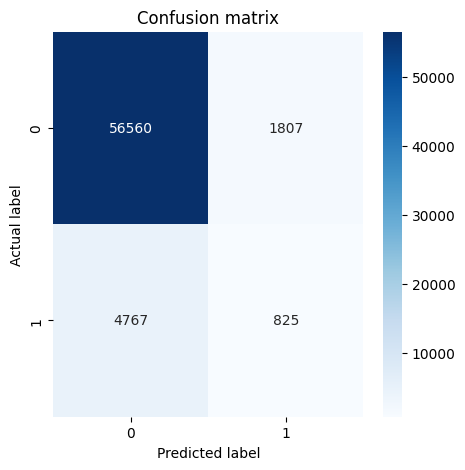

Accuracy: 0.909520161353367
Precision: 0.8709719219452536
Recall: 0.909520161353367
F1 score: 0.8785601165690415


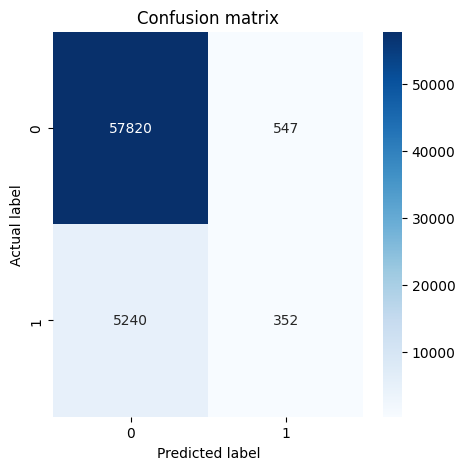

Accuracy: 0.9049547366281524
Precision: 0.8705908456043
Recall: 0.9049547366281524
F1 score: 0.8810561677373056


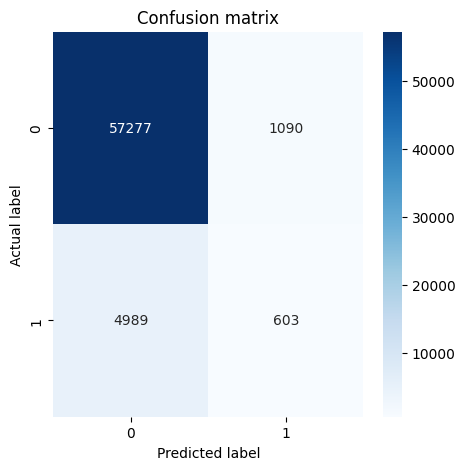

Accuracy: 0.9105208023890304
Precision: 0.8724321324286234
Recall: 0.9105208023890304
F1 score: 0.8781810290866752


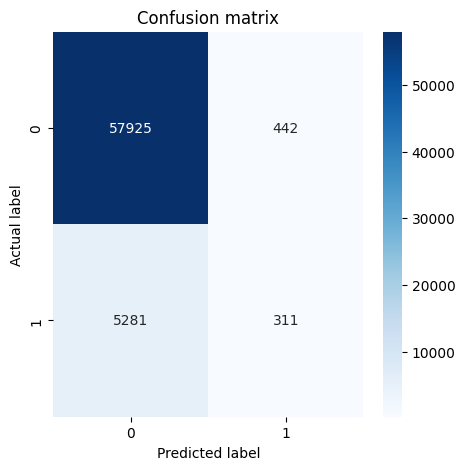

Accuracy: 0.9081442799293298
Precision: 0.8725290299644074
Recall: 0.9081442799293298
F1 score: 0.881014346279365


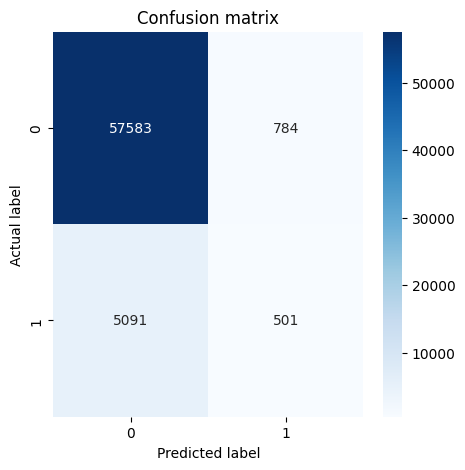

Accuracy: 0.9114901733923294
Precision: 0.8755976192799255
Recall: 0.9114901733923294
F1 score: 0.8786061057530923


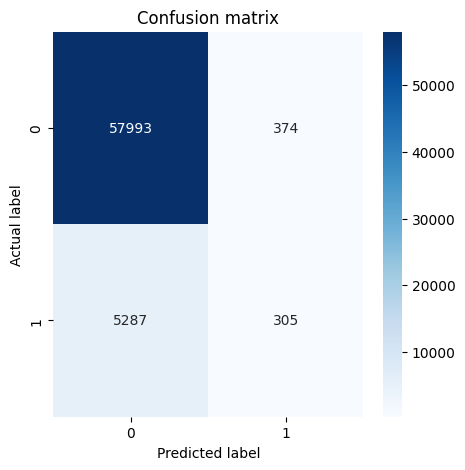

Accuracy: 0.9095357963695493
Precision: 0.8738102520416924
Recall: 0.9095357963695493
F1 score: 0.8807183596869489


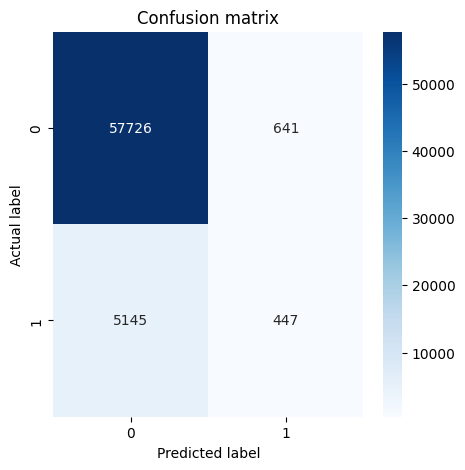

Accuracy: 0.911849778764521
Precision: 0.8764722982030999
Recall: 0.911849778764521
F1 score: 0.8782238252203336


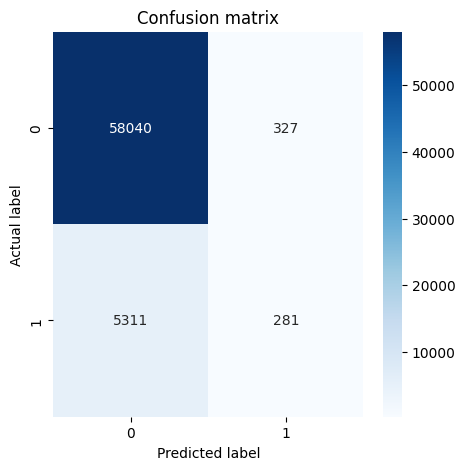

Accuracy: 0.9107396926155819
Precision: 0.8753785716449585
Recall: 0.9107396926155819
F1 score: 0.8802428871093819


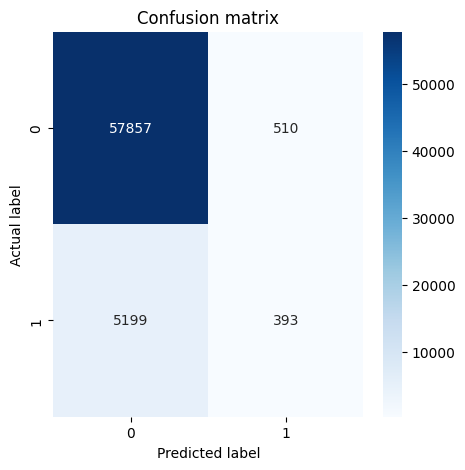

Accuracy: 0.9119592238777967
Precision: 0.8765095064280349
Recall: 0.9119592238777967
F1 score: 0.8777847600047157


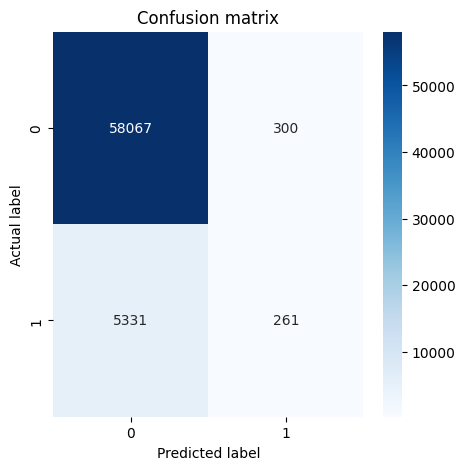

Accuracy: 0.9109273128097688
Precision: 0.8751458411482554
Recall: 0.9109273128097688
F1 score: 0.8796368725655311


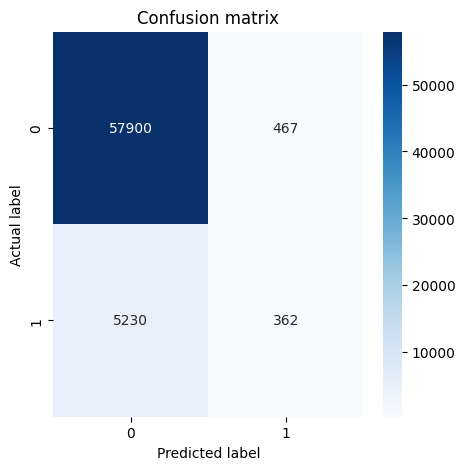

Accuracy: 0.9120061289263435
Precision: 0.8763453948764949
Recall: 0.9120061289263435
F1 score: 0.8773788836553184


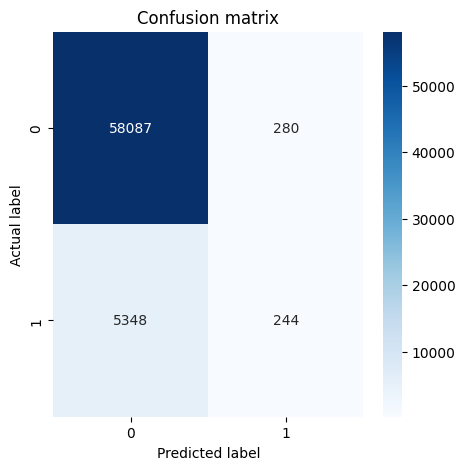

Accuracy: 0.9114276333276005
Precision: 0.875934099878814
Recall: 0.9114276333276005
F1 score: 0.8791276148416232


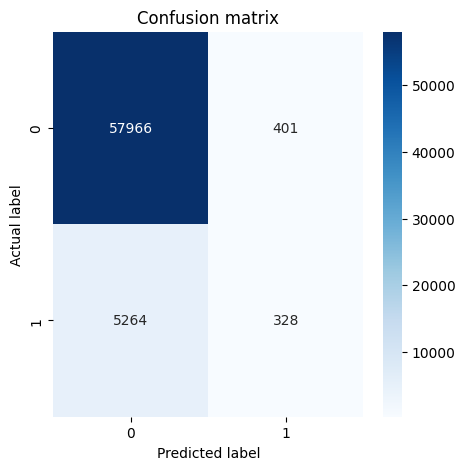

Accuracy: 0.9121937491205303
Precision: 0.8769440285588588
Recall: 0.9121937491205303
F1 score: 0.8770218421377376


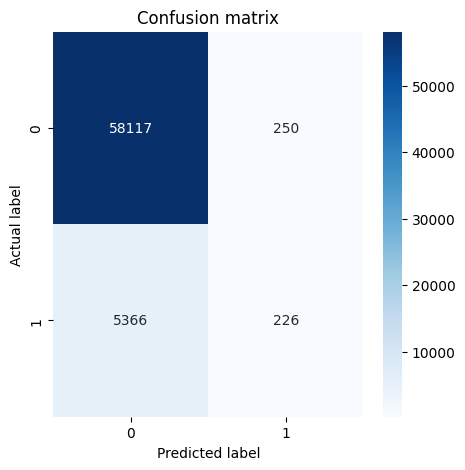

Accuracy: 0.9115683484732406
Precision: 0.875521542151155
Recall: 0.9115683484732406
F1 score: 0.8782829411947305


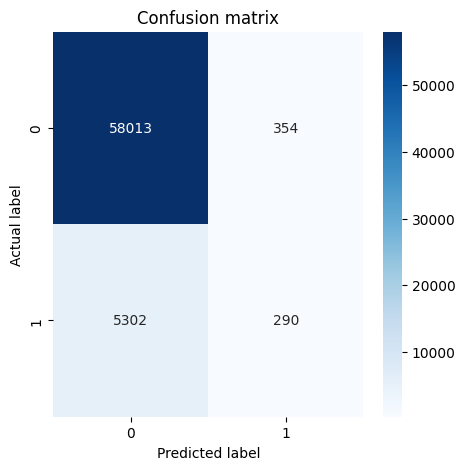

Accuracy: 0.9122406541690771
Precision: 0.8770681683977807
Recall: 0.9122406541690771
F1 score: 0.8768661847901371


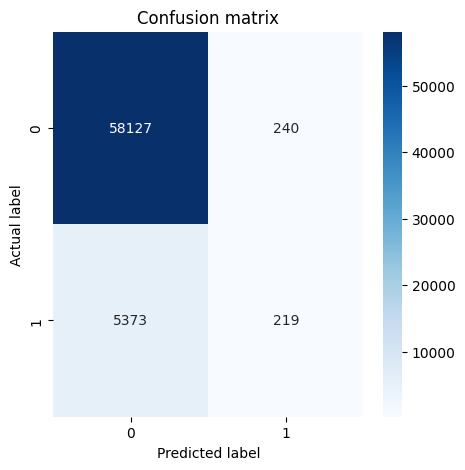

Accuracy: 0.911849778764521
Precision: 0.876216287827306
Recall: 0.911849778764521
F1 score: 0.8779483419985724


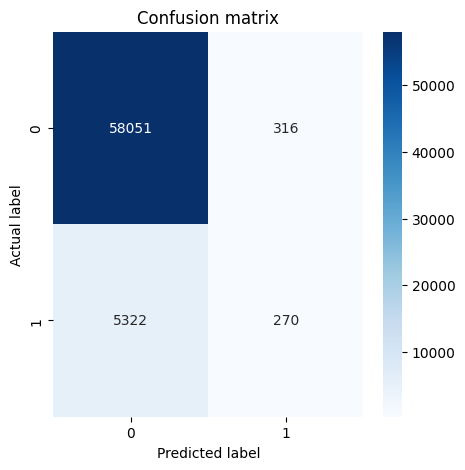

Text(0, 0.5, 'Testing Accuracy')

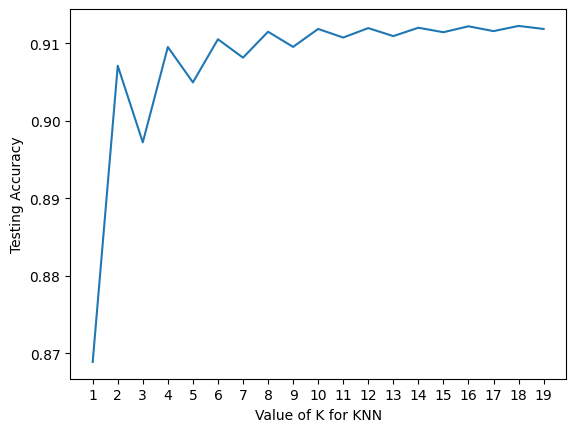

In [31]:
scores = []
n = 20

for k in range (1, n):
    clf = KNeighborsClassifier(n_neighbors=k)
    scores.append(runModel(clf))

# plot the relationship between K and testing accuracy
plt.plot(range(1, n), scores)
plt.xticks(np.arange(1, n, 1))
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')


In [32]:
# get max and its index
max_accuracy = np.max(scores)
max_accuracy_index = scores.index(max_accuracy)
print("Max accuracy: " + str(max_accuracy), "at k = " + str(max_accuracy_index + 1))

Max accuracy: 0.9122406541690771 at k = 18


We tested k-NN algorithm with different values of k. The best results were obtained with larger values of k, which is expected since the data is imbalanced. The best value obtained as around `0.91` with 18 neighbors. After that, the accuracy starts to stabilize with no significant improvement.

#### Random Forest

Accuracy: 0.8964649228411952
Precision: 0.868543248070838
Recall: 0.8964649228411952
F1 score: 0.8795332295512582


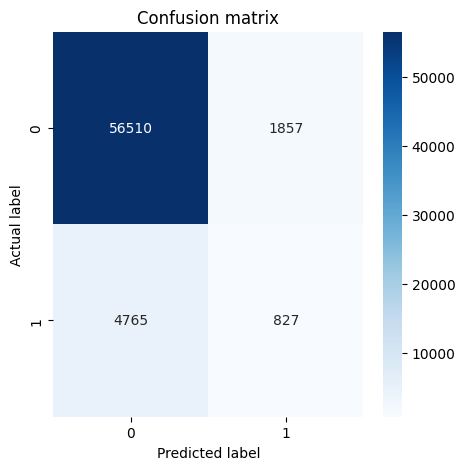

Accuracy: 0.8964649228411952


In [33]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
accuracy = runModel(clf)
print("Accuracy: " + str(accuracy))

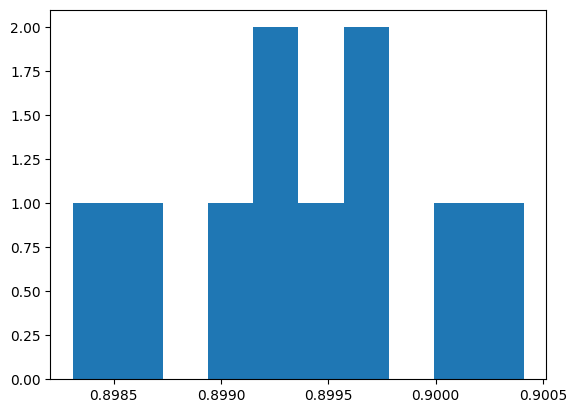

In [34]:
clf = RandomForestClassifier(n_estimators=100)
runModelRepeatedly(clf)

#### Naive Bayes

Accuracy: 0.8139745774636876
Precision: 0.8884998343375456
Recall: 0.8139745774636876
F1 score: 0.8432882924827042


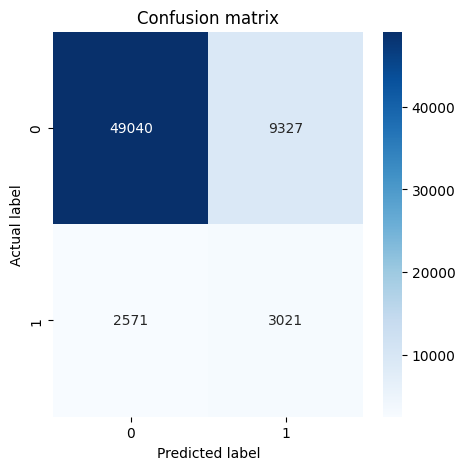

0.8139745774636876

In [35]:
# naive bayes
clf = GaussianNB()
runModel(clf)

#### Neural networks

Accuracy: 0.9138823308682125
Precision: 0.8864707336097413
Recall: 0.9138823308682125
F1 score: 0.8826527402585528


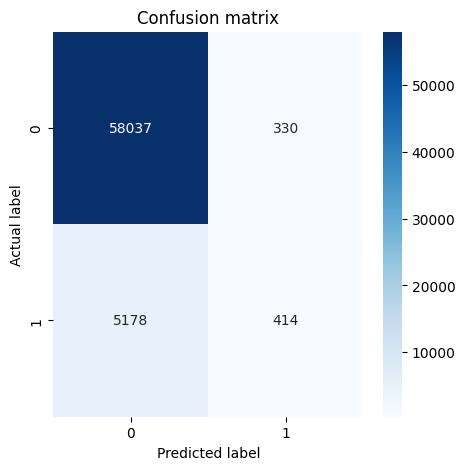

0.9138823308682125

In [36]:
clf = MLPClassifier(hidden_layer_sizes=(10, 5), activation='relu', solver='adam', max_iter=1000, random_state=42)
runModel(clf)

In [26]:


X = new_df.drop('HeartDisease', axis=1)
y = new_df['HeartDisease']

# Convert categorical variables into numerical using one-hot encoding
X = pd.get_dummies(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a neural network classifier
clf = MLPClassifier()

# Define the parameter grid to search over
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (10, 5)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'max_iter': [500, 1000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (10,), 'max_iter': 500, 'solver': 'adam'}
Best score: 0.9166419121206963
